In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install rockpool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 551.6/551.6 kB 30.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rockpool: filename=rockpool-3.0.0.1-py3-none-any.whl size=675969 sha256=7f01ca95dc3dc728fc3f1c809b6be4b1b52c35928d5e27ae34d2654236d913b3
  Stored in directory: /root/.cache/pip/wheels/2f/ad/d2/00853bb88a70f9830ea85f09f48f5efdccc86f4ff1f8ad3b8b
Successfully built rockpool


In [ ]:
! pip install "rockpool[all]"

  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of nirtorch to determine which version is compatible with other requirements. This could take a while.
  Using cached pybind11-3.0.0-py3-none-any.whl.metadata (10.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.7/96.7 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 M

In [3]:
# ==== 1. Importing Dependencies and Hardware Configuration ====
import torch
import numpy as np
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from rockpool.nn.networks import SynNet
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==== 2. loading data ====
X_train = torch.from_numpy(np.load("/content/drive/My Drive/SD-project/data/newdata/X_train.npy")).float()
y_train = torch.from_numpy(np.load("/content/drive/My Drive/SD-project/data/newdata/y_train.npy")).long()
X_val = torch.from_numpy(np.load("/content/drive/My Drive/SD-project/data/newdata/X_val.npy")).float()
y_val = torch.from_numpy(np.load("/content/drive/My Drive/SD-project/data/newdata/y_val.npy")).long()

print(f"Using device: {X_train.shape}")
print(f"Using device: {y_train.shape}")
print(f"Using device: {X_val.shape}")
print(f"Using device: {y_val.shape}")


/usr/local/lib/python3.11/dist-packages/rockpool/nn/networks/__init__.py:15: UserWarning: This module needs to be ported to the v2 API.
  warnings.warn(f"{err}")
/usr/local/lib/python3.11/dist-packages/rockpool/nn/networks/__init__.py:20: UserWarning: This module needs to be ported to the v2 API.
  warnings.warn(f"{err}")


Using device: cuda:0
Using device: torch.Size([2113, 100, 16])
Using device: torch.Size([2113])
Using device: torch.Size([374, 100, 16])
Using device: torch.Size([374])


In [4]:
train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)


train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, drop_last=True, pin_memory=True, num_workers=6)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False, drop_last=False, pin_memory=True, num_workers=6)



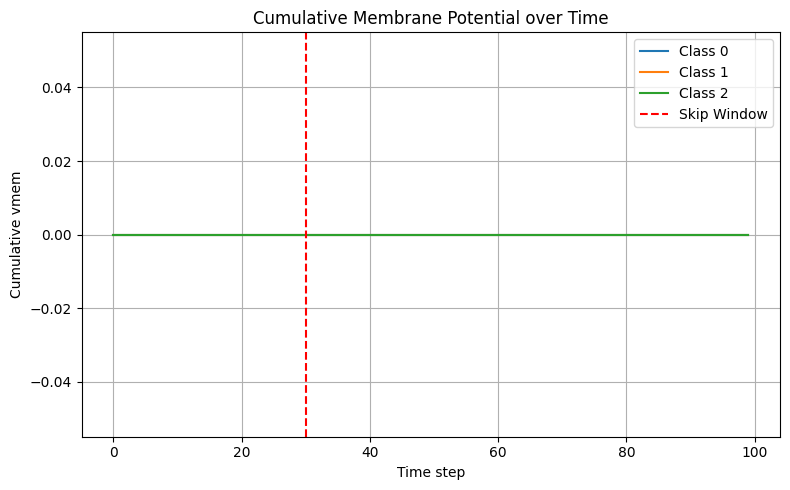

Epoch 0: 100%|██████████| 132/132 [01:48<00:00,  1.22it/s]

Epoch 0: Train Loss = 8.9948, Accuracy = 37.59%


  [Val] Accuracy: 39.04%
  ✅ New best model saved at epoch 0 with val acc 39.04%


Epoch 1: 100%|██████████| 132/132 [01:47<00:00,  1.23it/s]

Epoch 1: Train Loss = 8.1463, Accuracy = 39.30%


  [Val] Accuracy: 41.18%
  ✅ New best model saved at epoch 1 with val acc 41.18%


Epoch 2: 100%|██████████| 132/132 [01:47<00:00,  1.23it/s]

Epoch 2: Train Loss = 8.0576, Accuracy = 40.34%


  [Val] Accuracy: 39.04%


Epoch 3: 100%|██████████| 132/132 [01:47<00:00,  1.23it/s]

Epoch 3: Train Loss = 7.8789, Accuracy = 44.03%


  [Val] Accuracy: 51.87%
  ✅ New best model saved at epoch 3 with val acc 51.87%


Epoch 4: 100%|██████████| 132/132 [01:47<00:00,  1.23it/s]

Epoch 4: Train Loss = 7.3902, Accuracy = 54.83%


  [Val] Accuracy: 55.88%
  ✅ New best model saved at epoch 4 with val acc 55.88%


Epoch 5: 100%|██████████| 132/132 [01:47<00:00,  1.23it/s]

Epoch 5: Train Loss = 7.1507, Accuracy = 57.81%


  [Val] Accuracy: 61.76%
  ✅ New best model saved at epoch 5 with val acc 61.76%


Epoch 6: 100%|██████████| 132/132 [01:47<00:00,  1.23it/s]

Epoch 6: Train Loss = 7.2526, Accuracy = 58.29%


  [Val] Accuracy: 61.76%


Epoch 7: 100%|██████████| 132/132 [01:47<00:00,  1.23it/s]

Epoch 7: Train Loss = 7.0249, Accuracy = 59.38%


  [Val] Accuracy: 61.76%


Epoch 8: 100%|██████████| 132/132 [01:47<00:00,  1.23it/s]

Epoch 8: Train Loss = 6.9580, Accuracy = 59.42%


  [Val] Accuracy: 60.70%


Epoch 9: 100%|██████████| 132/132 [01:48<00:00,  1.22it/s]

Epoch 9: Train Loss = 6.8711, Accuracy = 59.28%


  [Val] Accuracy: 59.63%


Epoch 10: 100%|██████████| 132/132 [01:47<00:00,  1.22it/s]

Epoch 10: Train Loss = 7.0139, Accuracy = 59.56%


  [Val] Accuracy: 62.30%
  ✅ New best model saved at epoch 10 with val acc 62.30%


Epoch 11: 100%|██████████| 132/132 [01:48<00:00,  1.22it/s]

Epoch 11: Train Loss = 6.8088, Accuracy = 60.42%


  [Val] Accuracy: 58.29%


Epoch 12: 100%|██████████| 132/132 [01:47<00:00,  1.23it/s]

Epoch 12: Train Loss = 6.6277, Accuracy = 60.18%


  [Val] Accuracy: 59.63%


Epoch 13: 100%|██████████| 132/132 [01:47<00:00,  1.23it/s]

Epoch 13: Train Loss = 6.6590, Accuracy = 60.70%


  [Val] Accuracy: 60.16%


Epoch 14: 100%|██████████| 132/132 [01:47<00:00,  1.23it/s]

Epoch 14: Train Loss = 6.6885, Accuracy = 60.32%


  [Val] Accuracy: 60.96%


Epoch 15: 100%|██████████| 132/132 [01:47<00:00,  1.23it/s]

Epoch 15: Train Loss = 6.5432, Accuracy = 61.03%


  [Val] Accuracy: 59.63%


Epoch 16: 100%|██████████| 132/132 [01:47<00:00,  1.23it/s]

Epoch 16: Train Loss = 6.6018, Accuracy = 61.27%


  [Val] Accuracy: 61.76%


Epoch 17: 100%|██████████| 132/132 [01:47<00:00,  1.23it/s]

Epoch 17: Train Loss = 6.4056, Accuracy = 62.36%


  [Val] Accuracy: 63.64%
  ✅ New best model saved at epoch 17 with val acc 63.64%


Epoch 18: 100%|██████████| 132/132 [01:47<00:00,  1.22it/s]

Epoch 18: Train Loss = 6.3694, Accuracy = 62.03%


  [Val] Accuracy: 63.90%
  ✅ New best model saved at epoch 18 with val acc 63.90%


Epoch 19: 100%|██████████| 132/132 [01:47<00:00,  1.23it/s]

Epoch 19: Train Loss = 6.4853, Accuracy = 62.74%


  [Val] Accuracy: 60.43%


Epoch 20: 100%|██████████| 132/132 [01:47<00:00,  1.23it/s]

Epoch 20: Train Loss = 6.3316, Accuracy = 62.50%


  [Val] Accuracy: 67.11%
  ✅ New best model saved at epoch 20 with val acc 67.11%


Epoch 21: 100%|██████████| 132/132 [01:47<00:00,  1.23it/s]

Epoch 21: Train Loss = 6.1264, Accuracy = 64.87%


  [Val] Accuracy: 64.71%


Epoch 22: 100%|██████████| 132/132 [01:47<00:00,  1.23it/s]

Epoch 22: Train Loss = 6.1922, Accuracy = 65.77%


  [Val] Accuracy: 64.97%


Epoch 23: 100%|██████████| 132/132 [01:47<00:00,  1.22it/s]

Epoch 23: Train Loss = 6.1941, Accuracy = 65.58%


  [Val] Accuracy: 66.31%


Epoch 24: 100%|██████████| 132/132 [01:47<00:00,  1.23it/s]

Epoch 24: Train Loss = 5.9094, Accuracy = 66.81%


  [Val] Accuracy: 66.58%


Epoch 25: 100%|██████████| 132/132 [01:47<00:00,  1.23it/s]

Epoch 25: Train Loss = 5.9267, Accuracy = 65.58%


  [Val] Accuracy: 63.90%


Epoch 26: 100%|██████████| 132/132 [01:47<00:00,  1.22it/s]

Epoch 26: Train Loss = 5.6941, Accuracy = 67.80%


  [Val] Accuracy: 64.97%


Epoch 27: 100%|██████████| 132/132 [01:47<00:00,  1.23it/s]

Epoch 27: Train Loss = 5.6056, Accuracy = 68.70%


  [Val] Accuracy: 67.91%
  ✅ New best model saved at epoch 27 with val acc 67.91%


Epoch 28: 100%|██████████| 132/132 [01:47<00:00,  1.23it/s]

Epoch 28: Train Loss = 5.6512, Accuracy = 67.71%


  [Val] Accuracy: 68.18%
  ✅ New best model saved at epoch 28 with val acc 68.18%


Epoch 29: 100%|██████████| 132/132 [01:47<00:00,  1.23it/s]

Epoch 29: Train Loss = 5.4349, Accuracy = 69.32%


  [Val] Accuracy: 69.25%
  ✅ New best model saved at epoch 29 with val acc 69.25%


Epoch 30: 100%|██████████| 132/132 [01:48<00:00,  1.22it/s]

Epoch 30: Train Loss = 5.3677, Accuracy = 69.22%


  [Val] Accuracy: 68.98%


Epoch 31: 100%|██████████| 132/132 [01:47<00:00,  1.23it/s]

Epoch 31: Train Loss = 5.3038, Accuracy = 69.32%


  [Val] Accuracy: 71.66%
  ✅ New best model saved at epoch 31 with val acc 71.66%


Epoch 32: 100%|██████████| 132/132 [01:47<00:00,  1.22it/s]

Epoch 32: Train Loss = 5.2986, Accuracy = 69.27%


  [Val] Accuracy: 71.66%


Epoch 33: 100%|██████████| 132/132 [01:47<00:00,  1.22it/s]

Epoch 33: Train Loss = 5.3054, Accuracy = 69.32%


  [Val] Accuracy: 71.12%


Epoch 34: 100%|██████████| 132/132 [01:47<00:00,  1.23it/s]

Epoch 34: Train Loss = 5.1526, Accuracy = 70.08%


  [Val] Accuracy: 70.59%


Epoch 35: 100%|██████████| 132/132 [01:48<00:00,  1.22it/s]

Epoch 35: Train Loss = 5.1999, Accuracy = 69.55%


  [Val] Accuracy: 67.11%


Epoch 36: 100%|██████████| 132/132 [01:48<00:00,  1.22it/s]

Epoch 36: Train Loss = 5.2079, Accuracy = 68.75%


  [Val] Accuracy: 71.39%


Epoch 37: 100%|██████████| 132/132 [01:47<00:00,  1.23it/s]

Epoch 37: Train Loss = 5.2261, Accuracy = 69.98%


  [Val] Accuracy: 71.12%


Epoch 38: 100%|██████████| 132/132 [01:48<00:00,  1.22it/s]

Epoch 38: Train Loss = 5.0112, Accuracy = 70.93%


  [Val] Accuracy: 69.25%


Epoch 39: 100%|██████████| 132/132 [01:47<00:00,  1.23it/s]

Epoch 39: Train Loss = 4.9729, Accuracy = 70.45%


  [Val] Accuracy: 69.79%


Epoch 40: 100%|██████████| 132/132 [01:47<00:00,  1.22it/s]

Epoch 40: Train Loss = 4.9306, Accuracy = 71.64%


  [Val] Accuracy: 68.45%


Epoch 41: 100%|██████████| 132/132 [01:47<00:00,  1.23it/s]

Epoch 41: Train Loss = 4.9897, Accuracy = 70.69%


  [Val] Accuracy: 73.26%
  ✅ New best model saved at epoch 41 with val acc 73.26%


Epoch 42: 100%|██████████| 132/132 [01:47<00:00,  1.22it/s]

Epoch 42: Train Loss = 4.8726, Accuracy = 71.83%


  [Val] Accuracy: 72.73%


Epoch 43: 100%|██████████| 132/132 [01:47<00:00,  1.23it/s]

Epoch 43: Train Loss = 4.8353, Accuracy = 72.11%


  [Val] Accuracy: 74.06%
  ✅ New best model saved at epoch 43 with val acc 74.06%


Epoch 44: 100%|██████████| 132/132 [01:47<00:00,  1.23it/s]

Epoch 44: Train Loss = 4.7574, Accuracy = 72.54%


  [Val] Accuracy: 71.66%


Epoch 45: 100%|██████████| 132/132 [01:47<00:00,  1.23it/s]

Epoch 45: Train Loss = 4.8022, Accuracy = 71.92%


  [Val] Accuracy: 70.59%


Epoch 46: 100%|██████████| 132/132 [01:48<00:00,  1.22it/s]

Epoch 46: Train Loss = 4.7053, Accuracy = 72.68%


  [Val] Accuracy: 74.06%


Epoch 47: 100%|██████████| 132/132 [01:48<00:00,  1.22it/s]

Epoch 47: Train Loss = 4.6557, Accuracy = 72.92%


  [Val] Accuracy: 71.12%


Epoch 48: 100%|██████████| 132/132 [01:48<00:00,  1.21it/s]

Epoch 48: Train Loss = 4.6473, Accuracy = 72.87%


  [Val] Accuracy: 72.73%


Epoch 49: 100%|██████████| 132/132 [01:48<00:00,  1.22it/s]

Epoch 49: Train Loss = 4.6284, Accuracy = 72.82%


  [Val] Accuracy: 71.66%

🎯 Best Validation Accuracy: 74.06%


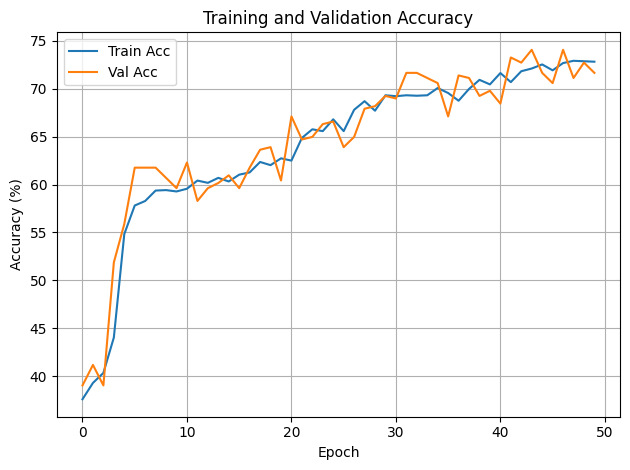

In [ ]:


# ==== 3. model ====
n_channels = 16
n_classes = 3

net = SynNet(
    output="vmem",
    p_dropout=0,
    n_channels=n_channels,
    n_classes=n_classes,
    size_hidden_layers=[24, 24, 24],
    time_constants_per_layer=[2, 4, 8],
).to(device)

#checkpoint_path = "/content/drive/My Drive/SD-project/best_snn_model_with_newMSE.pth"
#net.load_state_dict(torch.load(checkpoint_path, map_location=device))
optimizer = Adam(net.parameters().astorch(), lr=1e-3)
import matplotlib.pyplot as plt
import torch.nn.functional as F

# get a sample
xb, yb = next(iter(val_dl))
xb, yb = xb.to(device), yb.to(device)

net.eval()
with torch.no_grad():
    out, _, _ = net(xb)  # [B, T, C]

# get the output
vmem = out[0].cpu().numpy()  # shape: [T, C]
cumsum_vmem = vmem.cumsum(axis=0)  # shape: [T, C]

# plt fig
plt.figure(figsize=(8, 5))
for i in range(cumsum_vmem.shape[1]):
    plt.plot(cumsum_vmem[:, i], label=f'Class {i}')

plt.axvline(x=20, color='red', linestyle='--', label='Skip Window')
plt.title('Cumulative Membrane Potential over Time')
plt.xlabel('Time step')
plt.ylabel('Cumulative vmem')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==== 4. MSE defining ====
def float_target_mse_loss(outputs, labels, num_classes, pos_val=5.0, neg_val=-1.0):
    device = outputs.device
    B = labels.shape[0]
    target = torch.full((B, num_classes), neg_val, device=device)
    target[torch.arange(B, device=device), labels] = pos_val
    return F.mse_loss(outputs, target)

# ==== 5. training ====
n_epochs = 50
best_val_acc = 0.0
best_state = None
train_acc_list = []
train_loss_list = []
val_acc_list = []
skip_window = 20
for epoch in range(n_epochs):
    net.train()
    correct = 0
    total = 0
    total_loss = 0

    for xb, yb in tqdm(train_dl, desc=f"Epoch {epoch}"):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()

        out, _, _ = net(xb)                   # shape: [B, T, C]
        output = out[:, skip_window:, :].mean(dim=1)               # using sikp and mean value [B, C]
        loss = float_target_mse_loss(output, yb, num_classes=n_classes)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        pred = torch.argmax(output, dim=1)
        correct += (pred == yb.to(pred.device)).sum().item()
        total += yb.size(0)

    avg_loss = total_loss / total
    acc = 100 * correct / total
    train_acc_list.append(acc)
    train_loss_list.append(avg_loss)
    print(f"Epoch {epoch}: Train Loss = {avg_loss:.4f}, Accuracy = {acc:.2f}%")

    # ==== 验证 ====
    net.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            out, _, _ = net(xb)
            output = out[:, skip_window:, :].mean(dim=1)                    # using sikp and mean value vmem
            pred = torch.argmax(output, dim=1)
            correct += (pred == yb.to(pred.device)).sum().item()
            total += yb.size(0)

    val_acc = 100 * correct / total
    val_acc_list.append(val_acc)
    print(f"  [Val] Accuracy: {val_acc:.2f}%")

    # ==== 保存最佳模型 ====
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = net.state_dict()
        torch.save(best_state, "/content/drive/My Drive/SD-project/best_snn_model_with_newMSE_final.pth")
        print(f"  ✅ New best model saved at epoch {epoch} with val acc {val_acc:.2f}%")

print(f"\n🎯 Best Validation Accuracy: {best_val_acc:.2f}%")


# ==== 6. 可视化准确率 ====
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


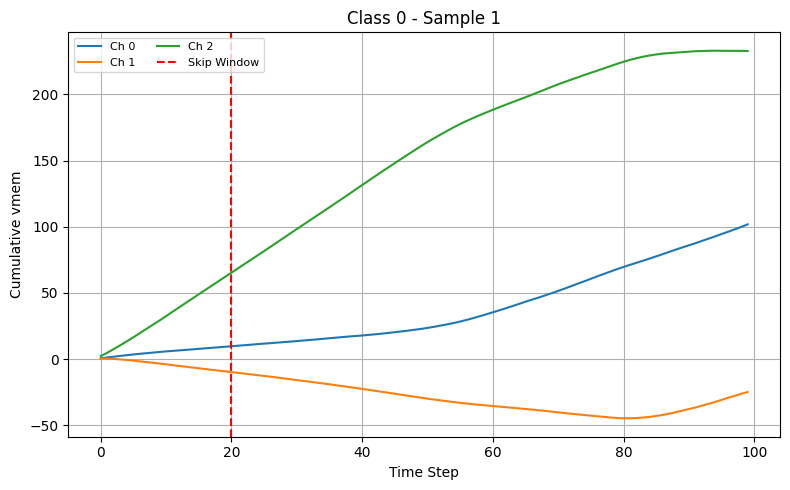

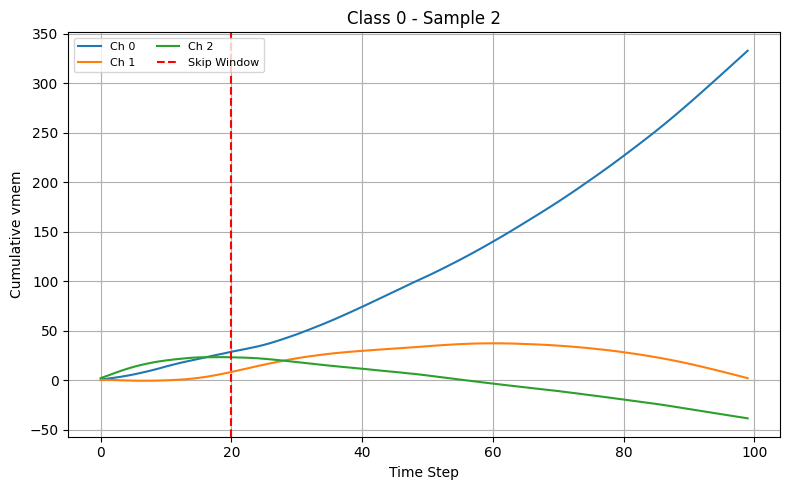

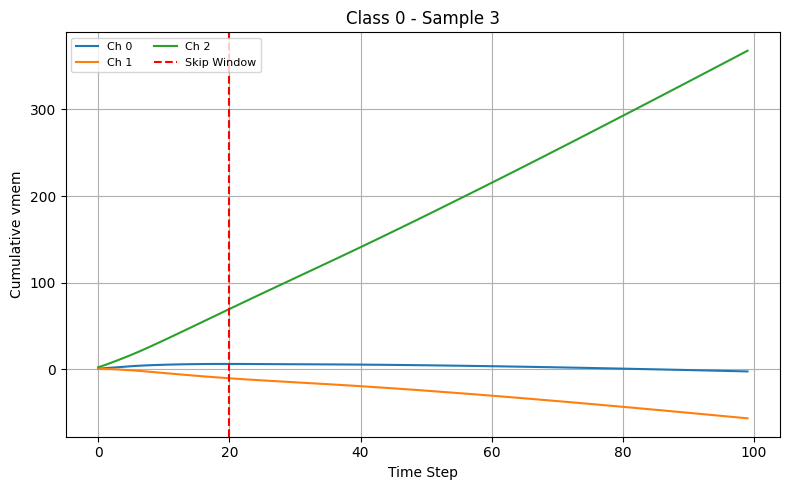

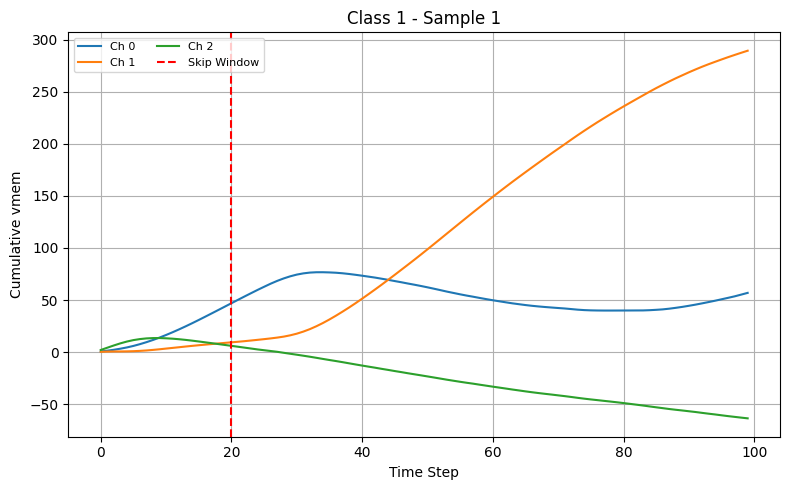

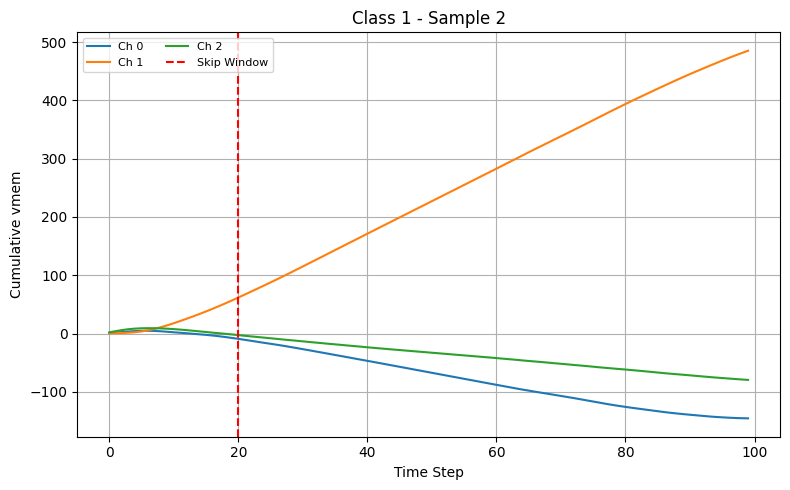

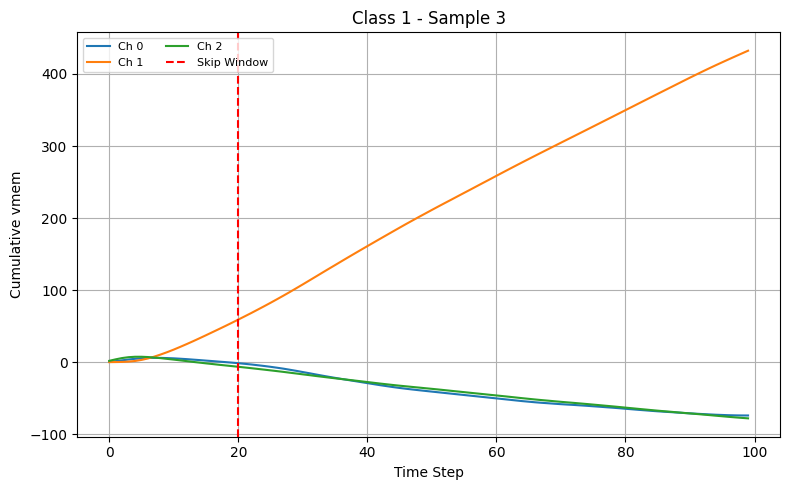

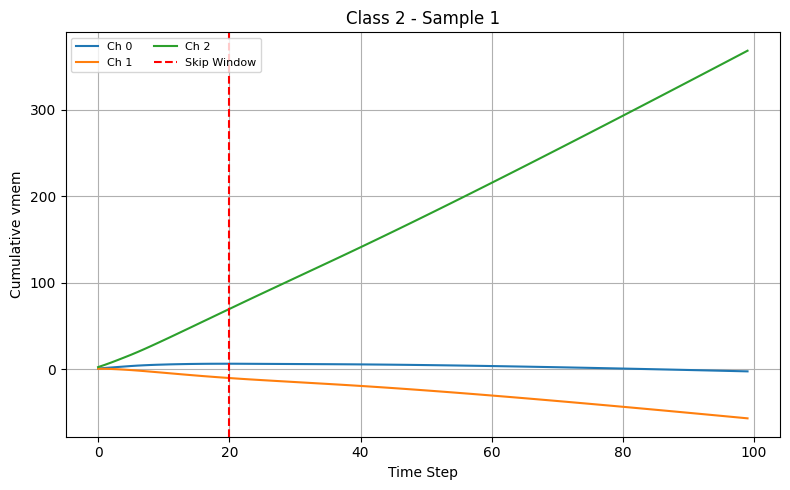

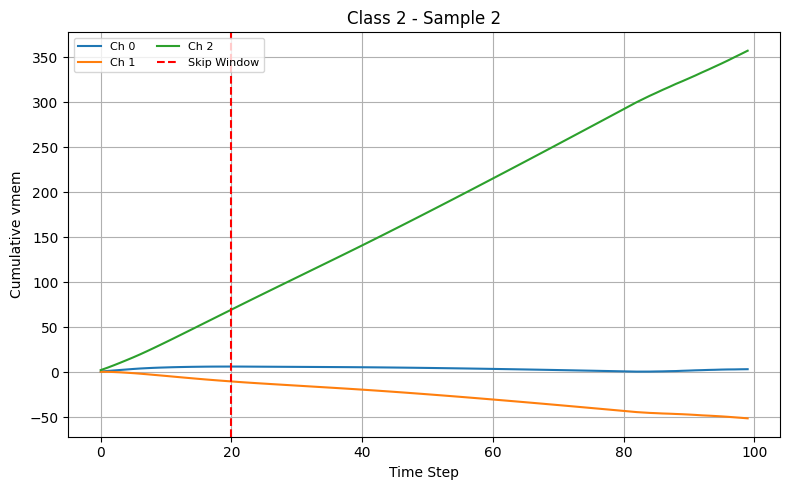

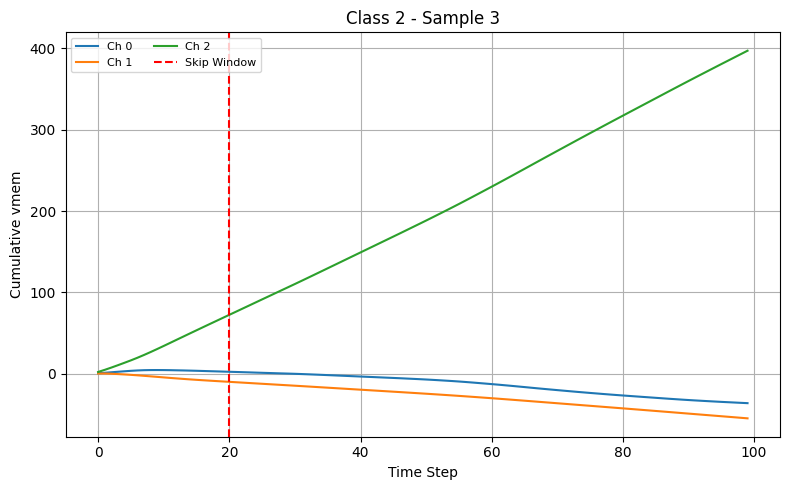

In [ ]:
# outpput show case after trained
import matplotlib.pyplot as plt
import torch
import numpy as np

net.eval()
n_classes = 3
skip_window = 20
samples_per_class = 3  # 每类展示几个样本

# 存储每类的样本
vmem_by_class = {i: [] for i in range(n_classes)}

with torch.no_grad():
    for xb, yb in val_dl:
        xb, yb = xb.to(device), yb.to(device)
        out, _, _ = net(xb)  # [B, T, C]

        for i in range(xb.size(0)):
            label = int(yb[i].item())
            if len(vmem_by_class[label]) < samples_per_class:
                vmem = out[i].cpu().numpy()  # shape: [T, C]
                cumsum_vmem = vmem.cumsum(axis=0)
                vmem_by_class[label].append(cumsum_vmem)

        if all(len(vmem_by_class[i]) >= samples_per_class for i in range(n_classes)):
            break  # 收集够了就停止

# === 分图绘制每个样本 ===
for cls in range(n_classes):
    for idx, cumsum_vmem in enumerate(vmem_by_class[cls]):
        plt.figure(figsize=(8, 5))
        for ch in range(cumsum_vmem.shape[1]):
            plt.plot(cumsum_vmem[:, ch], label=f'Ch {ch}')
        plt.axvline(x=skip_window, color='red', linestyle='--', label='Skip Window')
        plt.title(f'Class {cls} - Sample {idx+1}')
        plt.xlabel('Time Step')
        plt.ylabel('Cumulative vmem')
        plt.grid(True)
        plt.legend(ncol=2, fontsize=8, loc='upper left')
        plt.tight_layout()
        plt.show()


In [ ]:
X_test = torch.from_numpy(np.load("/content/drive/My Drive/SD-project/data/newdata/X_test.npy")).float()
y_test = torch.from_numpy(np.load("/content/drive/My Drive/SD-project/data/newdata/y_test.npy")).long()

test_ds = TensorDataset(X_test, y_test)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False, drop_last=True, pin_memory=True, num_workers=6)

import matplotlib.pyplot as plt
import torch.nn.functional as F

# 获取一个样本
xb, yb = next(iter(test_dl))
xb, yb = xb.to(device), yb.to(device)

net.eval()
with torch.no_grad():
    out, _, _ = net(xb)  # [B, T, C]

# 取第一个样本的输出（B=1）
vmem = out[0].cpu().numpy()  # shape: [T, C]
cumsum_vmem = vmem.cumsum(axis=0)  # shape: [T, C]

net.eval()
correct = 0
total = 0

with torch.no_grad():
    for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            out, _, _ = net(xb)
            output = out[:, skip_window:, :].mean(dim=1)                    # 仍然使用最后一帧 vmem
            pred = torch.argmax(output, dim=1)
            correct += (pred == yb.to(pred.device)).sum().item()
            total += yb.size(0)

val_acc = 100 * correct / total
val_acc_list.append(val_acc)
print(f"  [Val] Accuracy: {val_acc:.2f}%")

  [Val] Accuracy: 71.93%


In [ ]:


# ==== 3. 构建模型 ====
n_channels = 16
n_classes = 3

net = SynNet(
    output="vmem",
    p_dropout=0,
    n_channels=n_channels,
    n_classes=n_classes,
    size_hidden_layers=[24, 24, 24],
    time_constants_per_layer=[2, 4, 8],
).to(device)

#checkpoint_path = "/content/drive/My Drive/SD-project/best_snn_model_with_newMSE.pth"
#net.load_state_dict(torch.load(checkpoint_path, map_location=device))
optimizer = Adam(net.parameters().astorch(), lr=1e-3)
import matplotlib.pyplot as plt
import torch.nn.functional as F

# 获取一个样本
xb, yb = next(iter(val_dl))
xb, yb = xb.to(device), yb.to(device)

net.eval()
with torch.no_grad():
    out, _, _ = net(xb)  # [B, T, C]

# 取第一个样本的输出（B=1）
vmem = out[0].cpu().numpy()  # shape: [T, C]
cumsum_vmem = vmem.cumsum(axis=0)  # shape: [T, C]

# 绘图
plt.figure(figsize=(8, 5))
for i in range(cumsum_vmem.shape[1]):
    plt.plot(cumsum_vmem[:, i], label=f'Class {i}')

plt.axvline(x=20, color='red', linestyle='--', label='Skip Window')
plt.title('Cumulative Membrane Potential over Time')
plt.xlabel('Time step')
plt.ylabel('Cumulative vmem')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==== 4. 定义损失函数 ====
def float_target_mse_loss(outputs, labels, num_classes, pos_val=5.0, neg_val=-1.0):
    device = outputs.device
    B = labels.shape[0]
    target = torch.full((B, num_classes), neg_val, device=device)
    target[torch.arange(B, device=device), labels] = pos_val
    return F.mse_loss(outputs, target)

# ==== 5. 开始训练 ====
n_epochs = 50
best_val_acc = 0.0
best_state = None
train_acc_list = []
train_loss_list = []
val_acc_list = []
skip_window = 20
for epoch in range(n_epochs):
    net.train()
    correct = 0
    total = 0
    total_loss = 0

    for xb, yb in tqdm(train_dl, desc=f"Epoch {epoch}"):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()

        out, _, _ = net(xb)                   # shape: [B, T, C]
        output = out[:, skip_window:, :].mean(dim=1)               # using sikp and mean value [B, C]
        loss = float_target_mse_loss(output, yb, num_classes=n_classes)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        pred = torch.argmax(output, dim=1)
        correct += (pred == yb.to(pred.device)).sum().item()
        total += yb.size(0)

    avg_loss = total_loss / total
    acc = 100 * correct / total
    train_acc_list.append(acc)
    train_loss_list.append(avg_loss)
    print(f"Epoch {epoch}: Train Loss = {avg_loss:.4f}, Accuracy = {acc:.2f}%")

    # ==== 验证 ====
    net.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            out, _, _ = net(xb)
            output = out[:, skip_window:, :].mean(dim=1)                    # 仍然使用最后一帧 vmem
            pred = torch.argmax(output, dim=1)
            correct += (pred == yb.to(pred.device)).sum().item()
            total += yb.size(0)

    val_acc = 100 * correct / total
    val_acc_list.append(val_acc)
    print(f"  [Val] Accuracy: {val_acc:.2f}%")

    # ==== 保存最佳模型 ====
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = net.state_dict()
        torch.save(best_state, "/content/drive/My Drive/SD-project/best_snn_model_with_newMSE_final.pth")
        print(f"  ✅ New best model saved at epoch {epoch} with val acc {val_acc:.2f}%")

print(f"\n🎯 Best Validation Accuracy: {best_val_acc:.2f}%")


# ==== 6. 可视化准确率 ====
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
